In [18]:
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.io import wavfile
from scipy.stats import zscore

import pandas as pd
from util.path import Path
from util import subject
from constants import RUNS, NRUNS, TR

In [19]:
%cd ..

/scratch/gpfs/zzada/fconv


In [20]:
sub = 5
run = None
trial = None
item = None
first = None
conv = subject.get_conv(sub)

In [21]:
eventpath = Path(
    root="stimuli",
    conv=conv,
    datatype="transcript",
    run=run,
    trial=trial if trial is not None else None,
    item=item,
    condition=None,
    first=first,
    suffix="aligned",
    ext=".csv",
)
eventpath

stimuli/conv-105/transcript/conv-105_aligned.csv

In [22]:
search_str = eventpath.starstr(['conv', 'datatype'])
print(search_str)
files = glob(search_str)
for fn in files:
    print(fn)

stimuli/conv-105/transcript/conv-105*_aligned.csv
stimuli/conv-105/transcript/conv-105_run-3_set-2_trial-12_item-12_condition-G_first-B_aligned.csv
stimuli/conv-105/transcript/conv-105_run-2_set-1_trial-5_item-5_condition-G_first-A_aligned.csv
stimuli/conv-105/transcript/conv-105_run-1_set-1_trial-1_item-1_condition-G_first-B_aligned.csv
stimuli/conv-105/transcript/conv-105_run-4_set-2_trial-14_item-13_condition-G_first-B_aligned.csv
stimuli/conv-105/transcript/conv-105_run-5_set-3_trial-18_item-18_condition-G_first-A_aligned.csv
stimuli/conv-105/transcript/conv-105_run-2_set-1_trial-7_item-7_condition-G_first-A_aligned.csv
stimuli/conv-105/transcript/conv-105_run-3_set-2_trial-10_item-10_condition-G_first-A_aligned.csv
stimuli/conv-105/transcript/conv-105_run-4_set-3_trial-16_item-16_condition-G_first-B_aligned.csv
stimuli/conv-105/transcript/conv-105_run-5_set-3_trial-20_item-19_condition-G_first-B_aligned.csv
stimuli/conv-105/transcript/conv-105_run-1_set-1_trial-4_item-4_condition-

In [23]:
eventpath = Path.frompath(files[0].split('/')[-1])
eventpath.update(root='stimuli', datatype='transcript')
eventpath

stimuli/conv-105/transcript/conv-105_run-3_set-2_trial-12_item-12_condition-G_first-B_aligned.csv

# Visualize transcript

In [53]:
df = pd.read_csv(eventpath)
df.ffill(inplace=True)
df

,speaker,sentence,word,start,end,score
0,4,1,Um...,2.341,2.482,0.746
1,4,1,can,4.108,4.229,0.523
2,4,1,you,4.249,4.369,0.778
3,4,1,summarize,4.390,4.751,0.528
4,4,1,the,4.791,4.871,0.953
...,...,...,...,...,...,...
490,4,2,it,176.524,176.597,0.252
491,4,2,definitely,176.645,177.224,0.413
492,4,2,plays,177.297,177.562,0.735
493,4,2,a,177.659,177.900,0.576


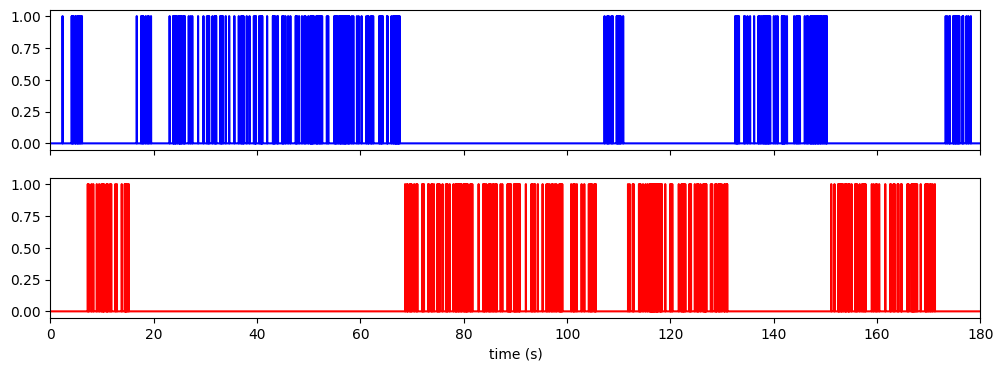

In [56]:
xaxis = np.arange(180 * 1000) / 1000

upto = int(df.start.max() * 1000) + 1
subA = np.zeros(180000)
subA[(df[df.speaker == sub].start * 1000).astype(int)] = 1

subB = np.zeros_like(subA)
subB[(df[df.speaker != sub].start * 1000).astype(int)] = 1

fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
axes[0].set_xlim(0, 180)
axes[0].plot(xaxis, subA, color="blue")
axes[1].plot(xaxis, subB, color="red")
axes[1].set_xlabel("time (s)")
fig.show()

# Fig 1

In [25]:
from encoding import build_regressors

In [24]:
run = eventpath['run']
trial = ((int(eventpath["trial"]) - 1) % 4) + 1
slices = [slice(i, i+240) for i in range(0, 1200, 240)]
run, trial

(3, 4)

In [30]:
X, features = build_regressors(sub, modelname='model-gpt2-medium_layer-0.75')
X.shape, features

((1200, 2311),
 {'task': slice(0, 9, None),
  'spectral': slice(9, 169, None),
  'articulation': slice(169, 213, None),
  'motion': slice(213, 263, None),
  'prod_semantic': slice(263, 1287, None),
  'comp_semantic': slice(1287, 2311, None)})

In [31]:
# get just one trial
Xt = X[slices[run-1]][:120]
Xt.shape

(120, 2311)

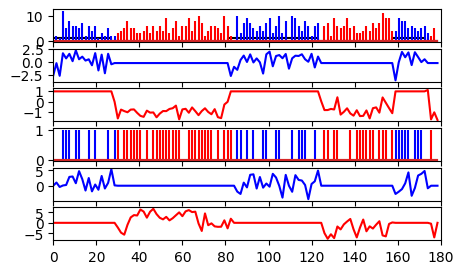

In [76]:
xaxis = np.arange(120) * 1.5
fig, axes = plt.subplots(6, 1, figsize=(5, 3), sharex=True)

# on off and phonemes
# axes[0].step(xaxis, Xt[:, 1], c='k')
axes[0].stem(xaxis, Xt[:, 3], markerfmt='', linefmt='b')
axes[0].stem(xaxis, Xt[:, 7], markerfmt='', linefmt='r')

# spectral channel
c = 13
axes[1].plot(xaxis, zscore(Xt[:, c]), c='blue')
axes[2].plot(xaxis, zscore(Xt[:, c+80]), c='red')

# axes[2].plot(xaxis, Xt[:, 25] + Xt[:, 25+80], c='k')

c = 2
axes[3].stem(xaxis, Xt[:, 169+c], markerfmt='', linefmt='b')
axes[3].stem(xaxis, Xt[:, 169+22+c], markerfmt='', linefmt='r')

axes[4].plot(xaxis, Xt[:, 263], c='blue')
axes[5].plot(xaxis, Xt[:, 263+1024], c='red')

fig.savefig('figures/fig1b-artifacts.svg')
axes[0].set_xlim(0, 180)
fig.show()

## fig 1a

In [10]:
id_vars = X[slices[run-1], [1, 2]][:120]
id_vars.shape

(120, 2)

In [77]:
# dfemb = subject.get_transcript(sub, modelname='model-gpt2-medium_layer-0.75')
# df2 = dfemb[(dfemb.run == run) & (dfemb.trial == eventpath['trial'])]
# df2['word,speaker,sentence,start'.split(',')]

In [11]:
data = subject.get_bold(sub, use_cache=True)
run_data = data[slices[run-1]]
trial_data = run_data[:120] # get first trial always (can fix later)
trial_data.shape

(120, 81924)

In [12]:
dataB = subject.get_bold(subject.get_partner(sub), use_cache=True)
run_dataB = dataB[slices[run-1]]
trial_dataB = run_dataB[:120] # get first trial always (can fix later)
trial_dataB.shape

(120, 81924)

In [13]:
audiopath = eventpath.copy()
audiopath.update(datatype='audio', suffix=None, ext='.wav')
fs, audio_data = wavfile.read(audiopath)
audio_data.shape

(2871296,)

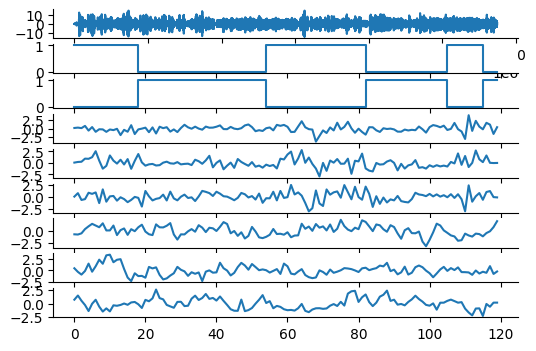

In [14]:
fig, axes = plt.subplots(9, 1, figsize=(6, 4))
axes[0].plot(zscore(audio_data))
axes[1+0].step(np.arange(120), id_vars[:, 0])
axes[1+1].step(np.arange(120), id_vars[:, 1])
axes[1+2].plot(zscore(trial_data[:, 1]))
axes[1+3].plot(zscore(trial_data[:, 0]))
axes[1+4].plot(zscore(trial_data[:, 3]))
axes[1+5].plot(zscore(trial_dataB[:, 1]))
axes[1+6].plot(zscore(trial_dataB[:, 0]))
axes[1+7].plot(zscore(trial_dataB[:, 300]))
for ax in axes:
    sns.despine(ax=ax)
# fig.savefig('figures/fig1-artifacts.svg')
fig.show()

In [15]:
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

In [22]:
bounds = np.diff(id_vars[:, 0]).nonzero()[0]

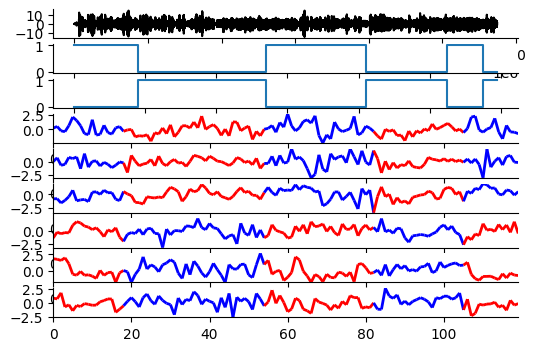

In [59]:
x = np.arange(120)

fig, axes = plt.subplots(9, 1, figsize=(6, 4))
axes[0].plot(zscore(audio_data), c='k')
axes[1+0].step(x, id_vars[:, 0])
axes[1+1].step(x, id_vars[:, 1])

for i in range(2, 5):
    ax = axes[1+i]
    y = zscore(trial_data[:, i])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = ListedColormap(['b', 'r', 'b', 'r', 'b'])
    norm = BoundaryNorm([0] + list(bounds), cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

for i in range(5, 8):
    ax = axes[1+i]
    y = zscore(trial_dataB[:, i])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = ListedColormap(['r', 'b', 'r', 'b', 'r',])
    norm = BoundaryNorm([0] + list(bounds), cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

for ax in axes:
    sns.despine(ax=ax)
fig.savefig('figures/fig1-artifacts.svg')
fig.show()

## brain plot

In [12]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
p = Plot(lh, rh)

 ...done. (2 seconds, 0 min)
Extracting data from /home/zzada/neuromaps-data/599046a594e0e45c04e90291c2348cbe/fsLR32k.tar.gz..... done.


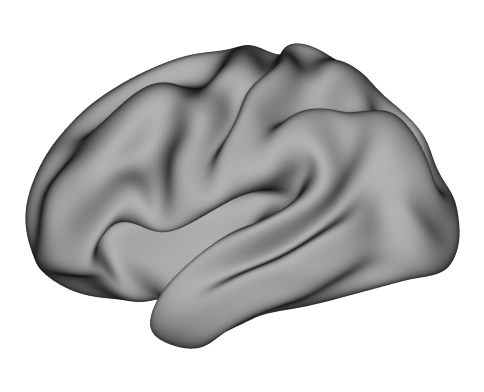

In [14]:
p = Plot(lh, views='lateral')
fig = p.build()
fig.savefig('figures/fig1-brains.svg')

# language hierarchy

In [9]:
from nltk.corpus import cmudict
arpabet = cmudict.dict()

In [2]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

In [16]:
doc = nlp("I put the lasagna in.")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.morph, arpabet.get(token.text.lower(), [None])[0])


I I PRON PRP nsubj Case=Nom|Number=Sing|Person=1|PronType=Prs ['AY1']
put put VERB VBD ROOT Tense=Past|VerbForm=Fin ['P', 'UH1', 'T']
the the DET DT det Definite=Def|PronType=Art ['DH', 'AH0']
lasagna lasagna PROPN NNP dobj Number=Sing ['L', 'AA0', 'S', 'AA1', 'N', 'Y', 'AH0']
in in ADP RP prt  ['IH0', 'N']
. . PUNCT . punct PunctType=Peri None


In [17]:
displacy.render(doc, style='dep')

# Custom atlas ROIS

In [13]:
import sys
from importlib import reload
reload(sys.modules['util.plot'])

from util.atlas import Atlas
from util import plot

fslr_params = dict(surface='fslr', density='32k', transform='fsaverage_to_fslr')

In [3]:
# from LanAtlas paper SI-I fig
rois = {
    'LH_SM': [f'L_{l}_ROI' for l in ['3b', '3a', '4']],
    'LH_EarlyAud': ['L_A1_ROI', 'L_A4_ROI', 'L_LBelt_ROI', 'L_PBelt_ROI', 'L_MBelt_ROI'],
    'LH_AntTemp': [f'L_{l}_ROI' for l in ['TA2', 'STSva', 'STSda', 'STGa', 'Pl', 'A5']],
    'LH_PostTemp': [f'L_{l}_ROI' for l in ['TPOJ1', 'TPOJ2', 'STV', 'STSvp', 'STSdp', 'PSL', 'PHT', 'PGi']],
    'LH_MFG': [f'L_{l}_ROI' for l in ['FEF', '55b']],
    'LH_IFG': [f'L_{l}_ROI' for l in ['IFSp', 'IFJa', '44']],
    'LH_IFGorb': [f'L_{l}_ROI' for l in ['47l', '45']],
    'LH_AngG': [f'L_{l}_ROI' for l in ['TPOJ3', 'PGs']],
    'LH_PMC': [f'L_{l}_ROI' for l in ['31a', '31pd', '31pv']],
    'LH_PreCun': ['L_POS2_ROI'],
}
flip = lambda x: ['R' + r[1:] for r in x]
rois |= {k.replace('LH_', 'RH_') : flip(v) for k, v in rois.items()}
len(rois)

20

In [6]:
atlas = Atlas.glasser2016()
label_img = np.zeros_like(atlas.label_img)
labels = {0: '???'}
for i, (k, v) in enumerate(rois.items(), 1):
    mask = atlas.roimask(v)
    print(i, k, v, mask.sum())
    label_img[mask] = i
    labels[i] = k
custom_atlas = Atlas('custom', label_img, labels)

1 LH_SM ['L_3b_ROI', 'L_3a_ROI', 'L_4_ROI'] 2166
2 LH_EarlyAud ['L_A1_ROI', 'L_A4_ROI', 'L_LBelt_ROI', 'L_PBelt_ROI', 'L_MBelt_ROI'] 818
3 LH_AntTemp ['L_TA2_ROI', 'L_STSva_ROI', 'L_STSda_ROI', 'L_STGa_ROI', 'L_Pl_ROI', 'L_A5_ROI'] 681
4 LH_PostTemp ['L_TPOJ1_ROI', 'L_TPOJ2_ROI', 'L_STV_ROI', 'L_STSvp_ROI', 'L_STSdp_ROI', 'L_PSL_ROI', 'L_PHT_ROI', 'L_PGi_ROI'] 1905
5 LH_MFG ['L_FEF_ROI', 'L_55b_ROI'] 371
6 LH_IFG ['L_IFSp_ROI', 'L_IFJa_ROI', 'L_44_ROI'] 442
7 LH_IFGorb ['L_47l_ROI', 'L_45_ROI'] 399
8 LH_AngG ['L_TPOJ3_ROI', 'L_PGs_ROI'] 430
9 LH_PMC ['L_31a_ROI', 'L_31pd_ROI', 'L_31pv_ROI'] 350
10 LH_PreCun ['L_POS2_ROI'] 302
11 RH_SM ['R_3b_ROI', 'R_3a_ROI', 'R_4_ROI'] 2050
12 RH_EarlyAud ['R_A1_ROI', 'R_A4_ROI', 'R_LBelt_ROI', 'R_PBelt_ROI', 'R_MBelt_ROI'] 643
13 RH_AntTemp ['R_TA2_ROI', 'R_STSva_ROI', 'R_STSda_ROI', 'R_STGa_ROI', 'R_Pl_ROI', 'R_A5_ROI'] 795
14 RH_PostTemp ['R_TPOJ1_ROI', 'R_TPOJ2_ROI', 'R_STV_ROI', 'R_STSvp_ROI', 'R_STSdp_ROI', 'R_PSL_ROI', 'R_PHT_ROI', 'R_PGi_ROI']

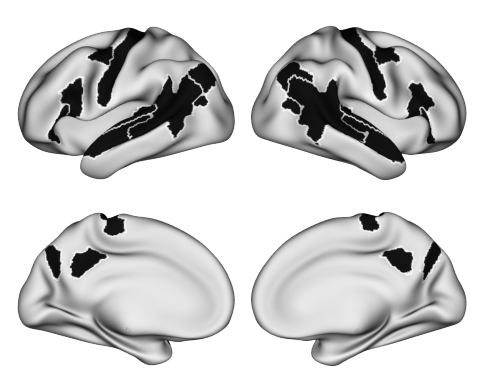

In [15]:
all_mask = (label_img > 0).astype(np.int32)
fig = plot.surface_plot(all_mask, atlas=custom_atlas, vmin=0, cmap='Greys', cbar=False, sulc_alpha=0.2, **fslr_params)
fig.savefig('figures/fig3-atlas-legend.svg')

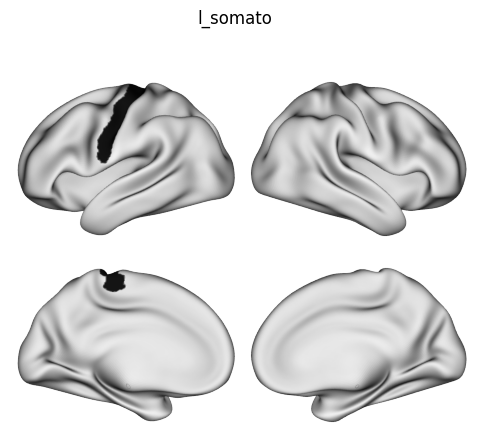

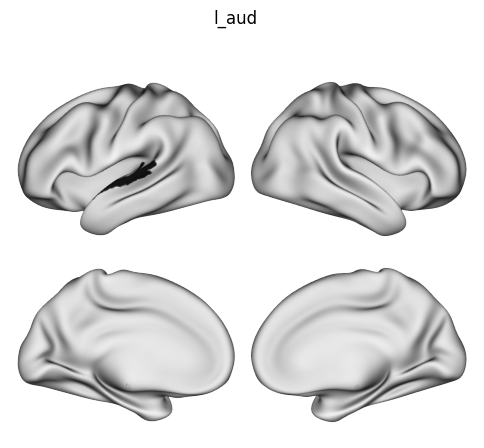

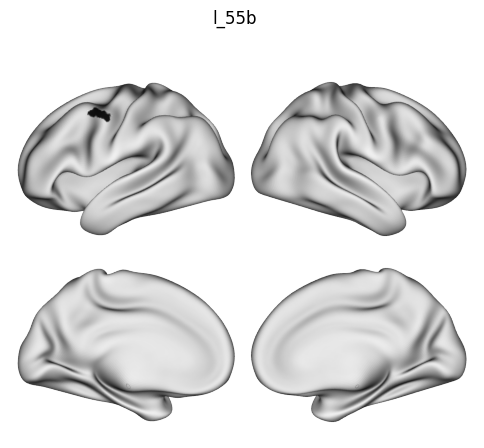

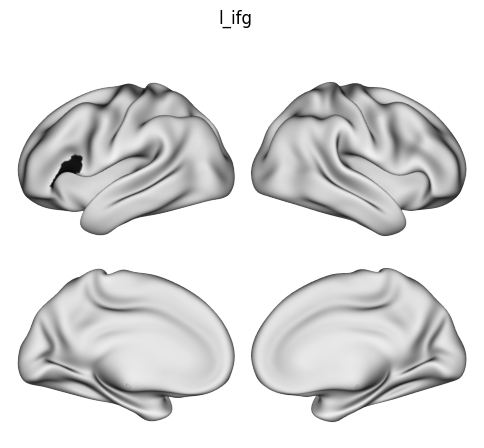

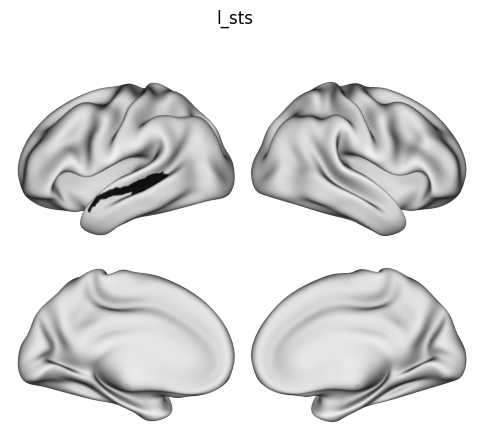

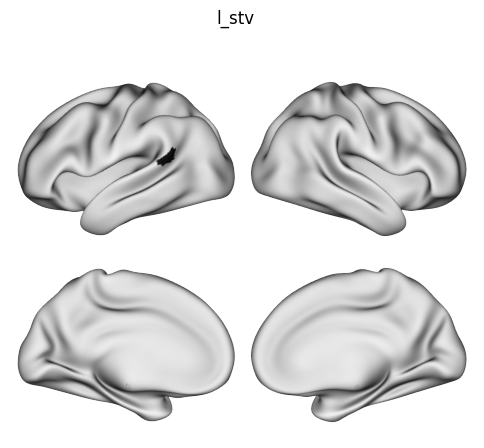

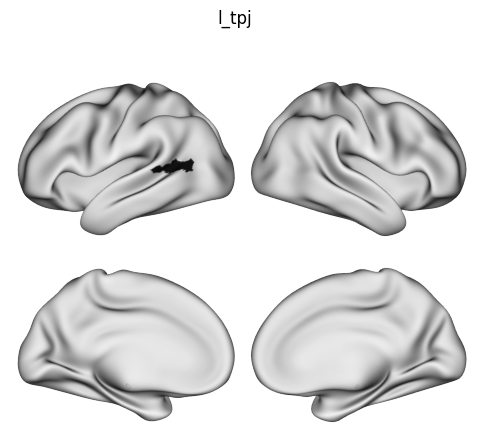

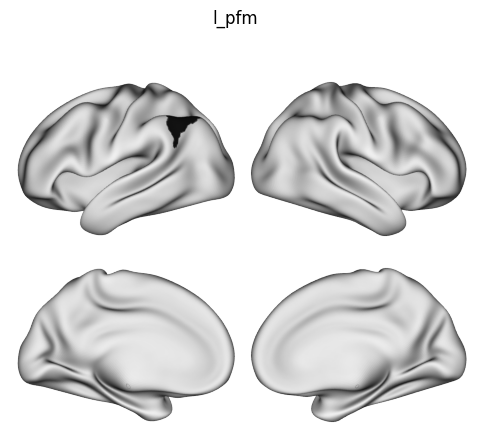

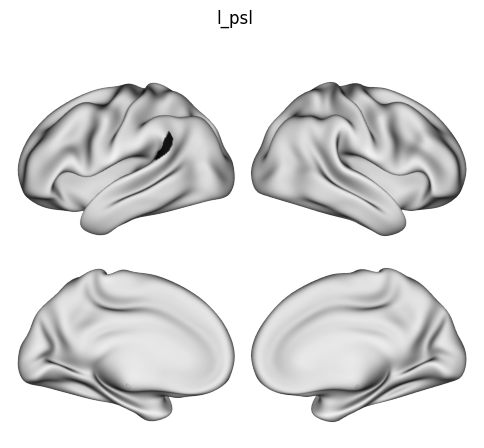

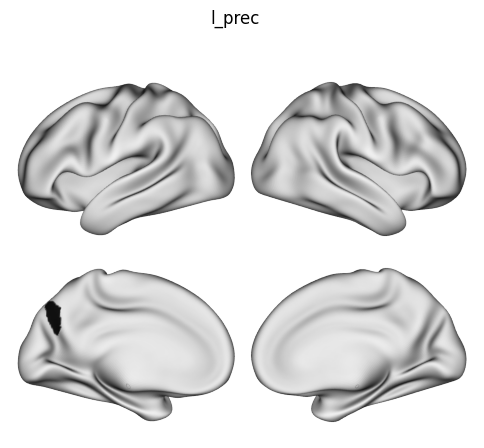

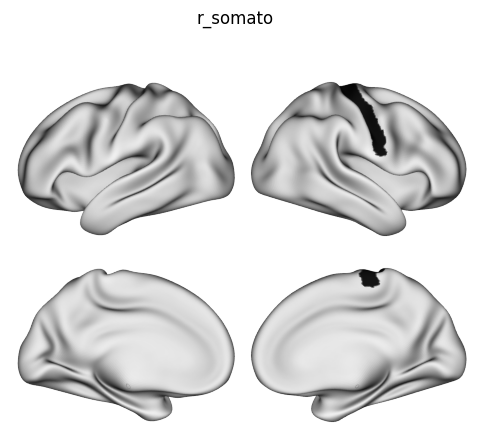

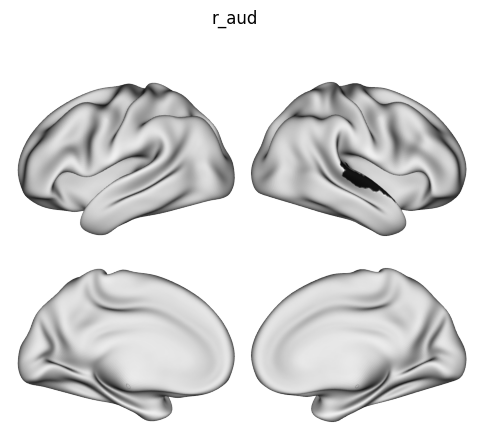

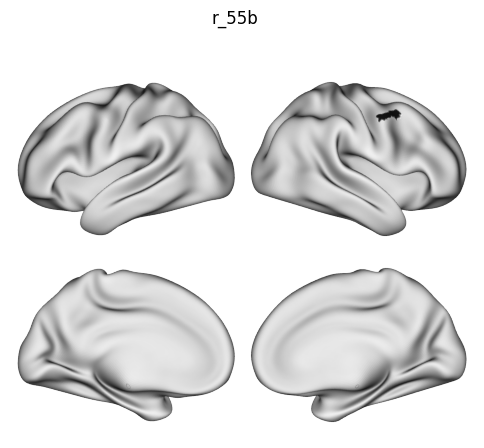

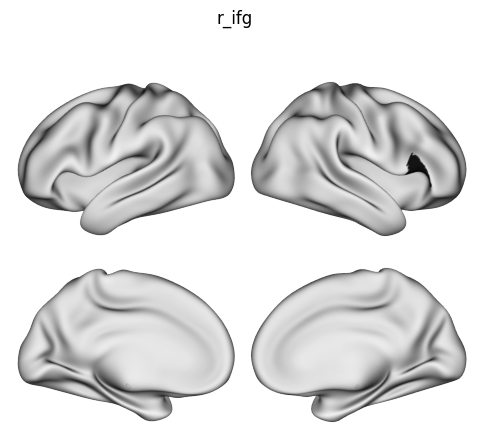

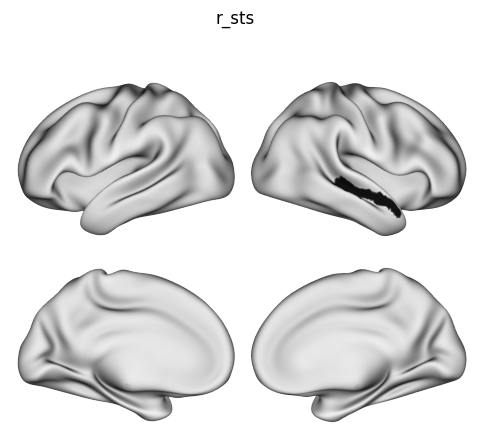

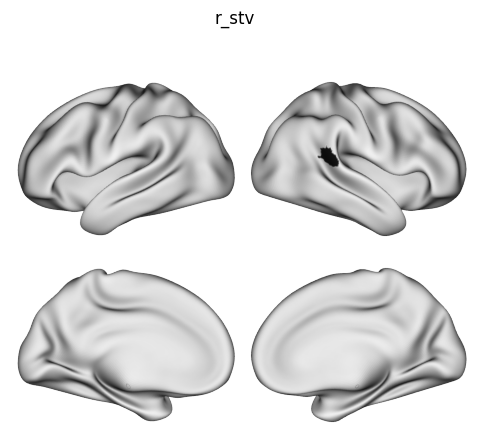

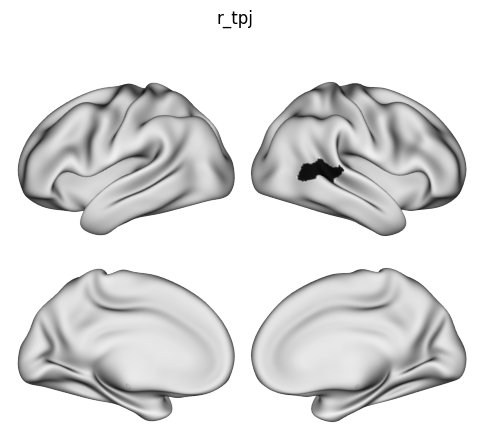

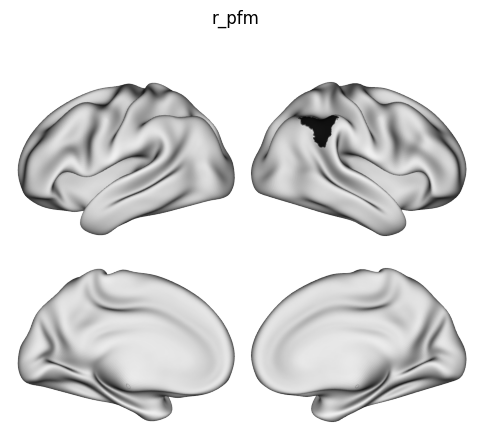

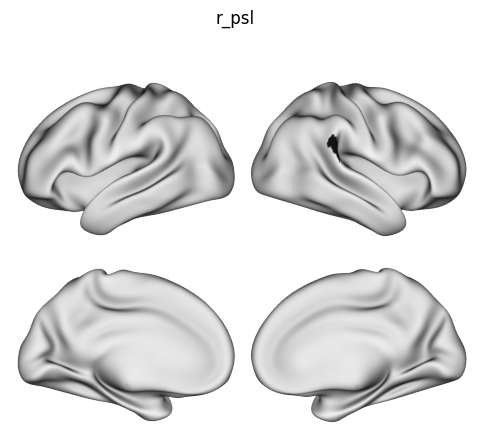

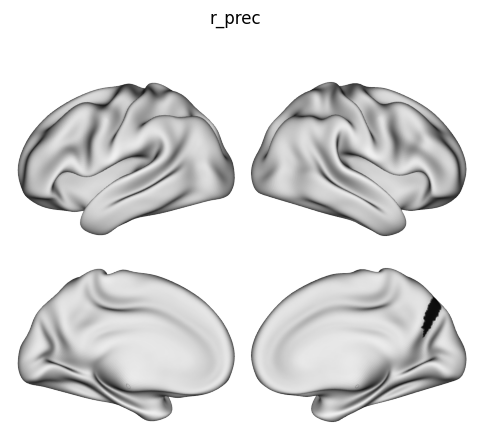

In [57]:
for label in custom_atlas.labels:
    mask = custom_atlas.roimask([label]).astype(np.int32)
    fig = plot.surface_plot(mask, vmin=0, vmax=1, cmap='Greys', cbar=False, sulc_alpha=0.2, **fslr_params)
    fig.suptitle(label)
    fig.show()